# Import Library

In [517]:
import mnist

In [518]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [519]:
# mx.set_default_device(mx.gpu)

# GAN Architecture

## Generator 👨🏻‍🎨

In [520]:
def GenBlock(in_dim:int,out_dim:int):
   
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.BatchNorm(out_dim, 0.8),
        nn.LeakyReLU(0.2)
    )

In [521]:
class Generator(nn.Module):

    def __init__(self, z_dim:int = 10, im_dim:int = 784, hidden_dim: int = 64):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            GenBlock(z_dim, hidden_dim),
            GenBlock(hidden_dim, hidden_dim * 2),
            GenBlock(hidden_dim * 2, hidden_dim * 4),

            nn.Linear(hidden_dim * 4,im_dim),
        )
        
    def __call__(self, noise):
        x = self.gen(noise)
        return mx.tanh(x)

In [522]:
gen = Generator(100)
gen

Generator(
  (gen): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=100, output_dims=64, bias=True)
      (layers.1): BatchNorm(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): LeakyReLU()
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=64, output_dims=128, bias=True)
      (layers.1): BatchNorm(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): LeakyReLU()
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=128, output_dims=256, bias=True)
      (layers.1): BatchNorm(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): LeakyReLU()
    )
    (layers.3): Linear(input_dims=256, output_dims=784, bias=True)
  )
)

In [523]:
# make 2D noise with shape n_samples x z_dim
def get_noise(n_samples:list[int], z_dim:int)->list[int]:
    return mx.random.normal(shape=(n_samples, z_dim))

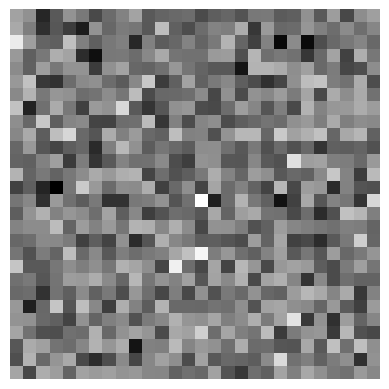

In [524]:
img = get_noise(28,28)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Discriminator 🕵🏻‍♂️

In [525]:
def DisBlock(in_dim:int,out_dim:int):
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.LeakyReLU(negative_slope=0.2),
        nn.Dropout(0.3),
    )

In [526]:
class Discriminator(nn.Module):

    def __init__(self,im_dim:int = 784, hidden_dim:int = 64):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            DisBlock(im_dim, hidden_dim * 4),
            DisBlock(hidden_dim * 4, hidden_dim * 2),
            DisBlock(hidden_dim * 2, hidden_dim),
            
            nn.Linear(hidden_dim,1),
            nn.Sigmoid()
        )
        
        
    def __call__(self, noise):
        return self.disc(noise)

In [527]:
disc = Discriminator()
disc

Discriminator(
  (disc): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=784, output_dims=256, bias=True)
      (layers.1): LeakyReLU()
      (layers.2): Dropout(p=0.30000000000000004)
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=256, output_dims=128, bias=True)
      (layers.1): LeakyReLU()
      (layers.2): Dropout(p=0.30000000000000004)
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=128, output_dims=64, bias=True)
      (layers.1): LeakyReLU()
      (layers.2): Dropout(p=0.30000000000000004)
    )
    (layers.3): Linear(input_dims=64, output_dims=1, bias=True)
    (layers.4): Sigmoid()
  )
)

# Model Training 🏋🏻‍♂️

### Losses

#### Discriminator Loss

In [528]:
def disc_loss(gen, disc, real, num_images, z_dim):
    
    noise =  mx.array(get_noise(num_images, z_dim))
    fake_images = gen(noise)
        
    fake_disc = disc(fake_images)
    
    fake_labels = mx.zeros((fake_images.shape[0],1))
            
    fake_loss = mx.mean(nn.losses.binary_cross_entropy(fake_disc,fake_labels,with_logits=True))
        
    real_disc = mx.array(disc(real))
    real_labels = mx.ones((real.shape[0],1))
    
    real_loss = mx.mean(nn.losses.binary_cross_entropy(real_disc,real_labels,with_logits=True))
    
    disc_loss = (fake_loss + real_loss)

    return disc_loss

#### Generator Loss

In [529]:
def gen_loss(gen, disc, num_images, z_dim):

    noise = mx.array(get_noise(num_images, z_dim))
    
    fake_images = gen(noise)
    fake_disc = mx.array(disc(fake_images))

    fake_labels = mx.ones((fake_images.shape[0],1))
            
    gen_loss = nn.losses.binary_cross_entropy(fake_disc,fake_labels,with_logits=True)
    
    return mx.mean(gen_loss)

In [530]:
# Get only the training images
train_images,train_labels,*_ = map(np.array, mnist.mnist())

In [531]:
# Normalize the images to fall between -1,1
train_images = train_images * 2.0 - 1.0

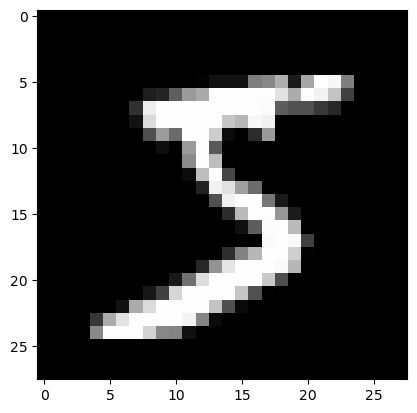

In [532]:
plt.imshow(train_images[0].reshape(28,28),cmap='gray')

In [533]:
def batch_iterate(batch_size: int, ipt: list[int])-> list[int]:
    perm = np.random.permutation(len(ipt))
    for s in range(0, len(ipt), batch_size):
        ids = perm[s : s + batch_size]
        yield ipt[ids]

In [534]:
def show_images(imgs:list[int],num_imgs:int = 25):
    if (imgs.shape[0] > 0): 
        fig,axes = plt.subplots(5, 5, figsize=(5, 5))
        
        for i, ax in enumerate(axes.flat):
            img = mx.array(imgs[i]).reshape(28,28)
            ax.imshow(img,cmap='gray')
            ax.axis('off')
        plt.show()

### show first batch of images

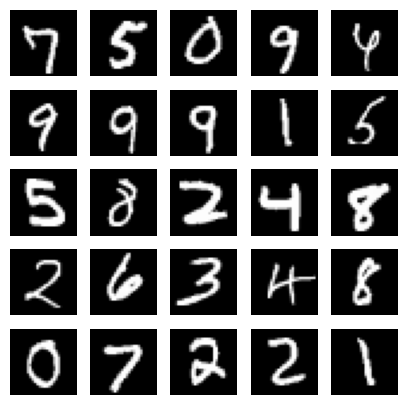

In [535]:
X = batch_iterate(25, train_images)
for x in X:  
    show_images(x)
    break

### Training Cycle

In [536]:
lr = 2e-6
z_dim = 128

gen = Generator(z_dim)
mx.eval(gen.parameters())
gen_opt = optim.Adam(learning_rate=lr, betas=[0.5, 0.999]) #,betas=[0.5, 0.9]

disc = Discriminator()
mx.eval(disc.parameters())
disc_opt = optim.Adam(learning_rate=lr, betas=[0.5, 0.999])

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, iteration: 468, Discriminator Loss:array(1.33504, dtype=float32), Generator Loss: array(0.460247, dtype=float32)


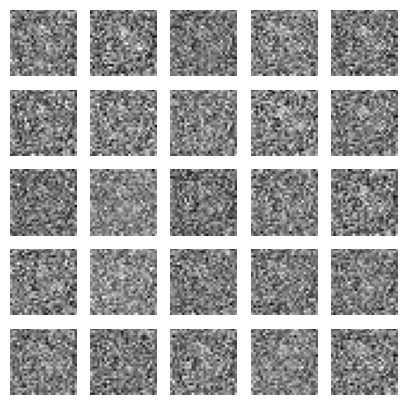

 20%|██        | 10/50 [00:48<03:09,  4.73s/it]

Epoch: 10, iteration: 468, Discriminator Loss:array(1.31833, dtype=float32), Generator Loss: array(0.469772, dtype=float32)


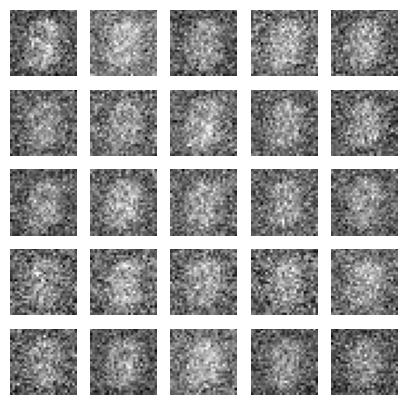

 40%|████      | 20/50 [01:35<02:22,  4.74s/it]

Epoch: 20, iteration: 468, Discriminator Loss:array(1.25664, dtype=float32), Generator Loss: array(0.526989, dtype=float32)


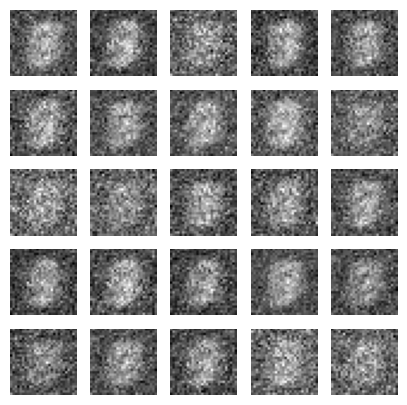

 60%|██████    | 30/50 [02:23<01:34,  4.74s/it]

Epoch: 30, iteration: 468, Discriminator Loss:array(1.16943, dtype=float32), Generator Loss: array(0.59993, dtype=float32)


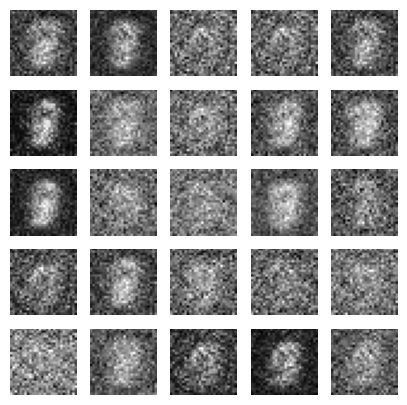

 80%|████████  | 40/50 [03:11<00:47,  4.74s/it]

Epoch: 40, iteration: 468, Discriminator Loss:array(1.11762, dtype=float32), Generator Loss: array(0.624788, dtype=float32)


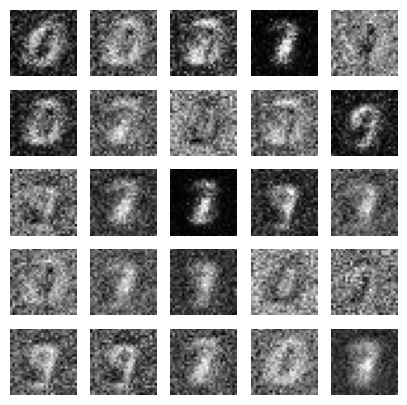

100%|██████████| 50/50 [03:58<00:00,  4.78s/it]


In [537]:
# Set your parameters
n_epochs = 50
display_step = 5000
cur_step = 0

batch_size = 128

D_loss_grad = nn.value_and_grad(disc, disc_loss)
G_loss_grad = nn.value_and_grad(gen, gen_loss)


for epoch in tqdm(range(n_epochs)):

    for idx,real in enumerate(batch_iterate(batch_size, train_images)):
                
        # TODO Train Discriminator
        D_loss,D_grads = D_loss_grad(gen, disc,mx.array(real), batch_size, z_dim)

        # Update optimizer
        disc_opt.update(disc, D_grads)
        
        # Update gradients
        mx.eval(disc.parameters(), disc_opt.state)

        # TODO Train Generator
        G_loss,G_grads = G_loss_grad(gen, disc, batch_size, z_dim)
        
        # Update optimizer
        gen_opt.update(gen, G_grads)
        
        # Update gradients
        mx.eval(gen.parameters(), gen_opt.state)        
        
        # if (cur_step + 1) % display_step == 0:
        #     print(f"Step {epoch}: Generator loss: {G_loss}, discriminator loss: {D_loss}")
        #     fake_noise = mx.array(get_noise(batch_size, z_dim))
        #     fake = gen(fake_noise)
        #     show_images(fake)
        #     show_images(real)
        # cur_step += 1
        
    if epoch%10==0:
            print("Epoch: {}, iteration: {}, Discriminator Loss:{}, Generator Loss: {}".format(epoch,idx,D_loss,G_loss))
            fake_noise = mx.array(get_noise(batch_size, z_dim))
            fake = gen(fake_noise)
            show_images(fake)
            # show_images(real)
            
    # print('Losses D={0} G={1}'.format(D_loss,G_loss))